<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#pip install finta
df = web.DataReader('0050.tw','yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [9]:
print(df.shape)
print(df.head(3))
print(df.tail(3))

(2877, 5)
                 High        Low       Open      Close     Volume
Date                                                             
2007-12-31  61.700001  61.049999  61.450001  61.450001  2870000.0
2008-01-02  61.299999  60.000000  60.099998  60.099998  4975000.0
2008-01-03  59.349998  58.599998  59.099998  59.099998  7413000.0
                 High        Low       Open      Close      Volume
Date                                                              
2019-09-04  82.199997  81.400002  81.449997  82.150002  10748771.0
2019-09-05  83.199997  82.550003  82.550003  83.000000  25429390.0
2019-09-06  83.550003  83.250000  83.250000  83.500000  17194000.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Labeling2 計算TOP and valley

In [0]:
def Labelling(Close_list):
  windowSize = 11
  countRow = 0
  labels = pd.Series( index = Close_list.index ,name = 'labels')
  while countRow < len(Close_list): #對row做遍歷
    countRow += 1
    if (countRow > windowSize):
      wbi = countRow - windowSize #計算一個區段的三個Index
      wei = wbi + windowSize -1
      wmi = (wbi+wei)/2
      min_ = Close_list[wbi] #初始化min_,max_等同該區段第一筆股價 
      max_ = Close_list[wbi]
      for i in range(wbi,wei+1,1):#對該區段做遍歷,計算Top和valley的Index
        num = Close_list[i]
        if num < min_:
          min_ = num
          minIndex = i
        if num > max_:
          max_ = num
          maxIndex = i
      if maxIndex == wmi: #如果最高價位發生在區段中間則賣出
        labels.iloc[i] = 'BUY'
      elif minIndex == wmi: #如果最低價位發生在區段中間則買進
        labels.iloc[i] = 'SELL'
      else: #如果都不是就持有
        labels.iloc[i] = 'HOLD'
  return labels      

# Label3

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)
df = df.join(ret)

In [11]:
df.head()

,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal
Date,,,,,,,,
2007-12-31,61.700001,61.049999,61.450001,61.450001,2870000.0,0.961757,2008-01-03,-1
2008-01-02,61.299999,60.000000,60.099998,60.099998,4975000.0,0.938436,2008-01-07,-1
2008-01-03,59.349998,58.599998,59.099998,59.099998,7413000.0,0.954315,2008-01-07,-1
2008-01-04,59.349998,58.049999,59.099998,59.099998,7686000.0,0.954315,2008-01-07,-1
2008-01-07,57.599998,56.299999,56.400002,56.400002,20041000.0,1.082447,2008-01-15,1


(50, 70)

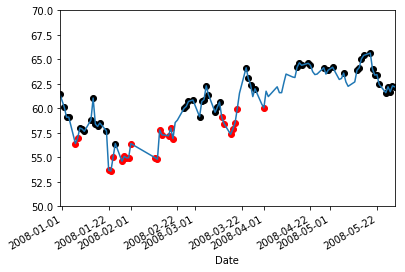

In [12]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:100].plot()
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
plt.ylim(50,70)

# 計算技術指標RSI

0.0 100.00000000000001


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI
Date,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523


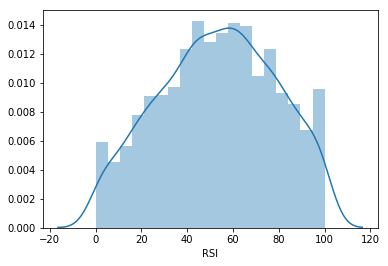

In [13]:
#計算絕對漲/跌幅
絕對漲幅 = (df['Close']/df['Close'].shift(1))-1 #(今天股價/昨日股價)-1
絕對漲幅[絕對漲幅<0] = 0 #跌幅的部份歸0
絕對跌幅 = (-1) * ((df['Close']/df['Close'].shift(1))-1) #-1 * ((今天股價/昨日股價)-1)#反向的絕對漲幅
絕對跌幅[絕對跌幅<0] = 0 #漲幅的部份歸0

#漲幅平滑
UPt = 絕對漲幅.rolling(6).mean()
DNt = 絕對跌幅.rolling(6).mean()

#計算RSI
df['RSI'] = 100 * UPt / (UPt+DNt)
print(df['RSI'].min(),df['RSI'].max())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

-100.0 -0.0


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869


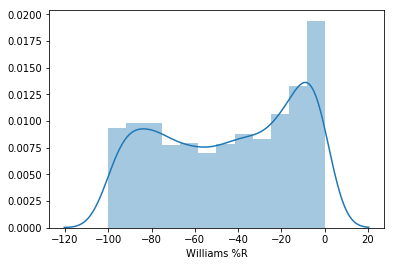

In [14]:
最近9日內最高價 = df['High'].rolling(9).max()
最近9日內最低價 = df['Low'].rolling(9).min()
df['Williams %R'] = (最近9日內最高價-df['Close'])/(最近9日內最高價-最近9日內最低價)
df['Williams %R'] = df['Williams %R'] * -100
print(df['Williams %R'].min(),df['Williams %R'].max())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    2873.000000
mean       62.187205
std        12.451018
min        30.008000
25%        53.800000
50%        60.180000
75%        71.050000
max        87.679999
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000


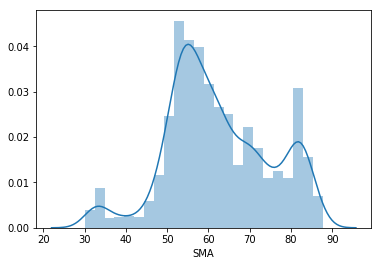

In [15]:
from finta import TA
ohlc = df[['Open','High','Low','Close','Volume']]
ohlc.columns = ['open','high','low','close','volume']
df['SMA'] = TA.SMA(ohlc,5)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    2877.000000
mean       62.169258
std        12.408653
min        30.751804
25%        53.796584
50%        60.290459
75%        70.972187
max        86.800883
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283


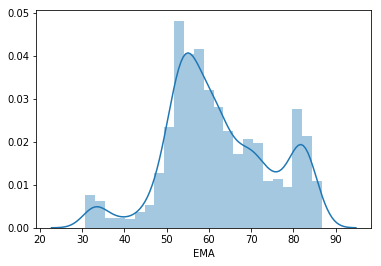

In [16]:
df['EMA'] = TA.EMA(ohlc)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    2869.000000
mean       62.165520
std        12.433770
min        30.099111
25%        53.821112
50%        60.232222
75%        71.011110
max        87.264444
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556


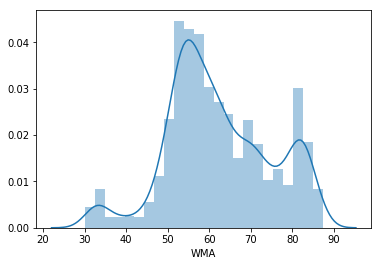

In [17]:
df['WMA'] = TA.WMA(ohlc)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    2874.000000
mean       62.186256
std        12.453690
min        29.586000
25%        53.766250
50%        60.182500
75%        71.128750
max        87.854999
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999


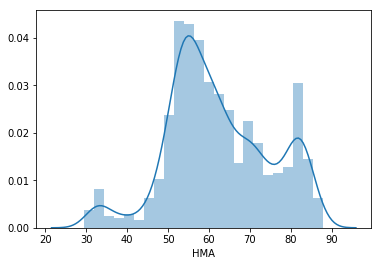

In [18]:
df['HMA'] = TA.HMA(ohlc)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    2877.000000
mean       62.199432
std        12.474058
min        29.280004
25%        53.796861
50%        60.261556
75%        71.148825
max        88.240036
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691


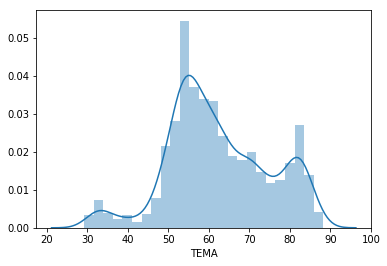

In [19]:
df['TEMA'] = TA.TEMA(ohlc)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    2876.000000
mean       11.290527
std        86.800065
min      -226.628960
25%       -56.936860
50%        22.095370
75%        82.556241
max       221.975646
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962


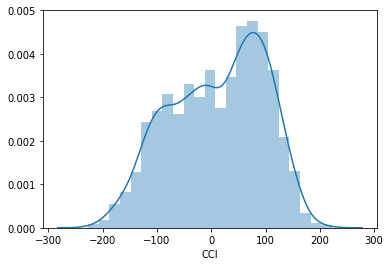

In [20]:
df['CCI'] = TA.CCI(ohlc)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    2868.000000
mean        5.795790
std        41.803346
min       -97.530901
25%       -25.000081
50%         5.537113
75%        36.999043
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198


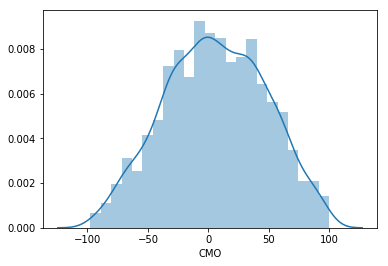

In [21]:
df['CMO'] = TA.CMO(ohlc)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    2877.000000
mean        0.000033
std         0.215907
min        -0.894187
25%        -0.132880
50%         0.004641
75%         0.142205
max         0.773870
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984


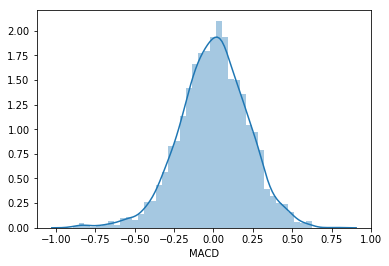

In [22]:
df['MACD'] = TA.MACD(ohlc)['MACD'] - TA.MACD(ohlc)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    2877.000000
mean        0.000087
std         0.383064
min        -2.154603
25%        -0.223186
50%         0.000829
75%         0.231133
max         2.330703
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881


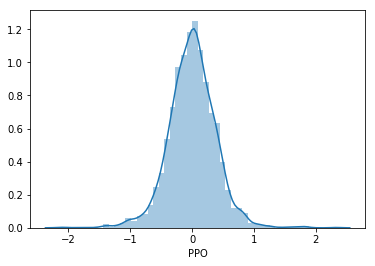

In [23]:
df['PPO'] = TA.PPO(ohlc)['PPO'] - TA.PPO(ohlc)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    2865.000000
mean        0.223087
std         4.117214
min       -25.105744
25%        -1.878360
50%         0.484427
75%         2.622500
max        19.192592
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420


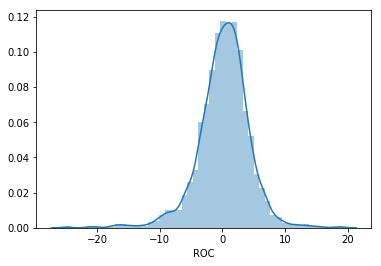

In [24]:
df['ROC'] = TA.ROC(ohlc)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    2868.000000
mean        5.795790
std        41.803346
min       -97.530901
25%       -25.000081
50%         5.537113
75%        36.999043
max       100.000000
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,27.500014
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,4.444377
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,19.626203
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,32.786852
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,73.333198


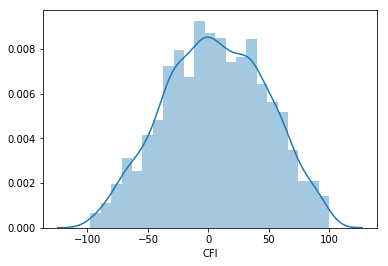

In [25]:
df['CFI'] = TA.CMO(ohlc)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    2794.000000
mean       -0.642832
std        22.381371
min      -127.770346
25%       -13.539123
50%         1.638485
75%        14.735095
max        70.975012
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,27.500014,11.995912
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,4.444377,3.011767
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,19.626203,5.926209
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,32.786852,21.704096
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,73.333198,24.639314


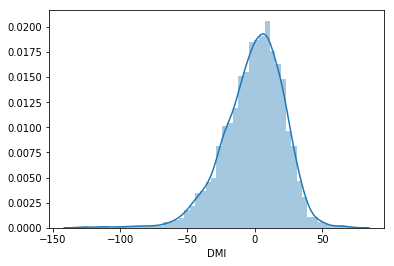

In [26]:
df['DMI'] = TA.DMI(ohlc)['DI+'] - TA.DMI(ohlc)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    2877.000000
mean       62.045070
std        12.555531
min        27.870001
25%        53.894021
50%        59.978199
75%        70.747998
max        88.400002
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-09-02,82.000000,81.650002,81.800003,81.900002,6457870.0,NaN,NaT,0,62.698693,-4.166600,80.910001,80.950204,80.684445,80.885001,81.603058,143.717155,27.500014,0.180702,0.223065,1.992526,27.500014,11.995912,79.594105
2019-09-03,82.000000,81.199997,81.849998,81.199997,5052925.0,NaN,NaT,0,76.622808,-33.333439,81.180000,81.000163,80.651111,81.275001,81.552079,96.940970,4.444377,0.171747,0.212018,2.266997,4.444377,3.011767,79.834694
2019-09-04,82.199997,81.400002,81.449997,82.150002,10748771.0,NaN,NaT,0,81.317962,-1.922902,81.530000,81.230130,80.621112,81.764999,81.962576,120.541026,19.626203,0.220213,0.271799,2.240203,19.626203,5.926209,80.051225
2019-09-05,83.199997,82.550003,82.550003,83.000000,25429390.0,NaN,NaT,0,82.631139,-5.555473,82.020000,81.584104,80.655556,81.850000,82.618155,164.641823,32.786852,0.295244,0.363960,2.722768,32.786852,21.704096,80.309077
2019-09-06,83.550003,83.250000,83.250000,83.500000,17194000.0,NaN,NaT,0,83.984523,-1.315869,82.350000,81.967283,81.045556,82.074999,83.251691,160.812962,73.333198,0.359984,0.442881,3.086420,73.333198,24.639314,80.713806


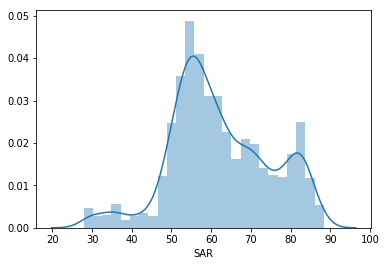

In [27]:
df['SAR'] = TA.SAR(ohlc)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [28]:
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為rolling計算技術指標導致
features = df.columns[6:].tolist()
y_name = 'triple_barrier_signal'
df = df[features+[y_name]]
print(df.shape)
df.head()

(2775, 18)


,triple_barrier_sell_time,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,,,
2008-05-08,2008-06-04,0,38.789222,-78.723425,63.299999,63.382882,63.654445,63.085000,62.924831,-106.919003,-15.463947,-0.248012,-0.398158,-2.941173,-15.463947,-62.962853,65.579519,0
2008-05-09,2008-06-05,0,26.891090,-91.999982,62.910000,63.156306,63.627778,63.064999,62.489224,-135.200512,-23.809558,-0.297035,-0.474788,-3.338512,-23.809558,-35.185195,65.376748,0
2008-05-12,2008-06-06,0,30.066838,-69.811367,62.860000,63.065045,63.438889,62.970000,62.449469,-111.339184,-28.712934,-0.288934,-0.461280,-1.647058,-28.712934,-26.013218,65.110608,0
2008-05-13,2008-05-26,-1,63.232365,-21.568487,63.030000,63.232036,63.388889,62.685001,63.031329,-13.260110,7.142896,-0.196984,-0.315131,0.709221,7.142896,9.343968,64.789547,-1
2008-05-14,2008-05-26,-1,64.648572,-11.764547,63.140001,63.415629,63.264444,62.905001,63.539091,41.376611,4.587165,-0.117408,-0.188882,1.023624,4.587165,14.747127,64.500593,-1


In [29]:
df = df.iloc[:,2:]
df.head()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2008-05-08,38.789222,-78.723425,63.299999,63.382882,63.654445,63.085000,62.924831,-106.919003,-15.463947,-0.248012,-0.398158,-2.941173,-15.463947,-62.962853,65.579519,0
2008-05-09,26.891090,-91.999982,62.910000,63.156306,63.627778,63.064999,62.489224,-135.200512,-23.809558,-0.297035,-0.474788,-3.338512,-23.809558,-35.185195,65.376748,0
2008-05-12,30.066838,-69.811367,62.860000,63.065045,63.438889,62.970000,62.449469,-111.339184,-28.712934,-0.288934,-0.461280,-1.647058,-28.712934,-26.013218,65.110608,0
2008-05-13,63.232365,-21.568487,63.030000,63.232036,63.388889,62.685001,63.031329,-13.260110,7.142896,-0.196984,-0.315131,0.709221,7.142896,9.343968,64.789547,-1
2008-05-14,64.648572,-11.764547,63.140001,63.415629,63.264444,62.905001,63.539091,41.376611,4.587165,-0.117408,-0.188882,1.023624,4.587165,14.747127,64.500593,-1


# 相關性分析

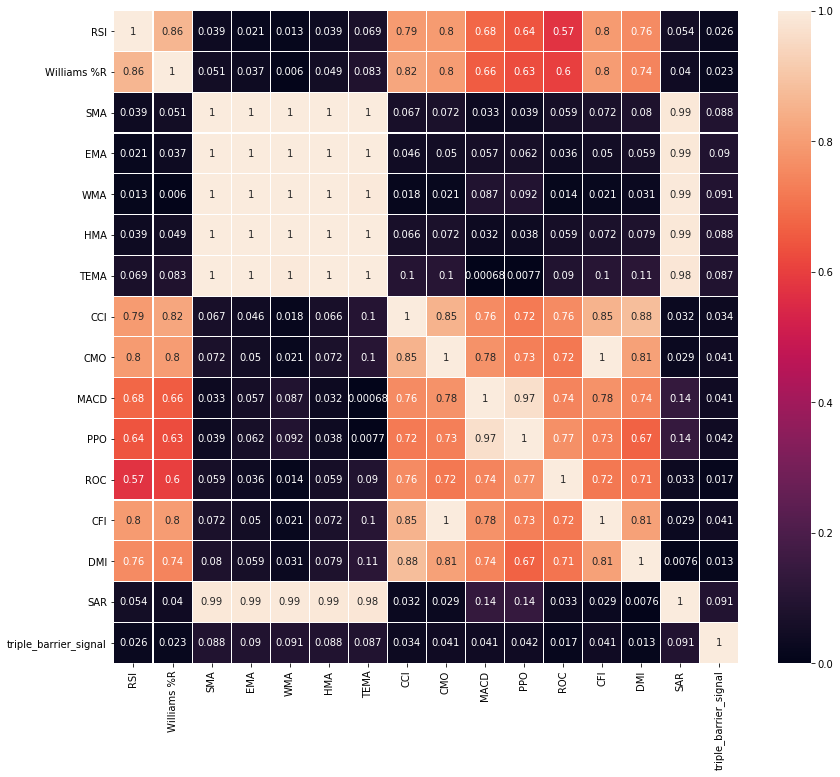

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,index=df.index,columns=df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
print(df_minmax.describe())
df_minmax.tail()

               RSI  Williams %R  ...          SAR  triple_barrier_signal
count  2775.000000  2775.000000  ...  2775.000000            2775.000000
mean      0.531829     0.553283  ...     0.563786              -0.292973
std       0.256611     0.315337  ...     0.209532               0.600052
min       0.000000     0.000000  ...     0.000000              -1.000000
25%       0.341438     0.256226  ...     0.426883              -1.000000
50%       0.540315     0.588236  ...     0.527507               0.000000
75%       0.730974     0.851851  ...     0.710887               0.000000
max       1.000000     1.000000  ...     1.000000               1.000000

[8 rows x 16 columns]


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-08-02,0.061267,0.106060,0.910875,0.924824,0.931582,0.911102,0.889601,0.132118,0.162999,0.353703,0.397682,0.516305,0.162999,0.448469,0.924467,0
2019-08-05,0.056486,0.062500,0.899431,0.916127,0.928103,0.899775,0.873266,0.106239,0.092241,0.282848,0.365783,0.497136,0.092241,0.413280,0.921267,0
2019-08-06,0.000000,0.301886,0.888681,0.908990,0.923458,0.886561,0.863037,0.108845,0.092241,0.246957,0.349504,0.487869,0.092241,0.323719,0.916332,0
2019-08-07,0.000000,0.230769,0.877930,0.901854,0.916344,0.872316,0.854004,0.188617,0.032499,0.222131,0.338087,0.466593,0.032499,0.366274,0.908343,0
2019-08-08,0.239054,0.413462,0.872208,0.899535,0.910144,0.866825,0.857001,0.292453,0.225128,0.257907,0.354196,0.487085,0.225128,0.454078,0.901153,0


In [32]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [33]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

for i in tqdm(range(b_index,f_index,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features]#取i:i+days這段時間的features(不包括i+days這一天),例如0,1,2...14日這些日期的features
  #y = df.iloc[i+days:i+days+1,:][y_name]#取i+days這一天的y_name,例如第15日y_name
  y = df.iloc[i+days-1:i+days+1-1,:][y_name]
  X = np.array(X) #2維df表格轉成2維np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,df.iloc[[i+days]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 2760/2760 [00:08<00:00, 327.33it/s]


準備完成


# check

In [34]:
print('資料筆數:',len(df))
print('第一筆的index開始和結束',indexs[0])
print('最後一筆的index開始和結束',indexs[-1])

資料筆數: 2775
第一筆的index開始和結束 (DatetimeIndex(['2008-05-08'], dtype='datetime64[ns]', name='Date', freq=None), DatetimeIndex(['2008-05-29'], dtype='datetime64[ns]', name='Date', freq=None))
最後一筆的index開始和結束 (DatetimeIndex(['2019-07-18'], dtype='datetime64[ns]', name='Date', freq=None), DatetimeIndex(['2019-08-08'], dtype='datetime64[ns]', name='Date', freq=None))


# Reshape X

(圖片數量,長,寬,1張)

In [35]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(2760, 15, 15)
(2760, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [36]:
print(ys.shape)
print(ys[:5])

(2760, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]


轉換成 漲或跌 的one_hot_array

In [37]:
from keras.utils.np_utils import to_categorical
#r1 = (ys>0)
#r2 = (ys<0)
#ys[r1] = int(1)
#ys[r2] = int(0)
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

Using TensorFlow backend.


(2760, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

In [38]:
print(Xs.shape)
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
print(Xs_v.shape)

(2760, 15, 15, 1)
(2760, 15, 15)


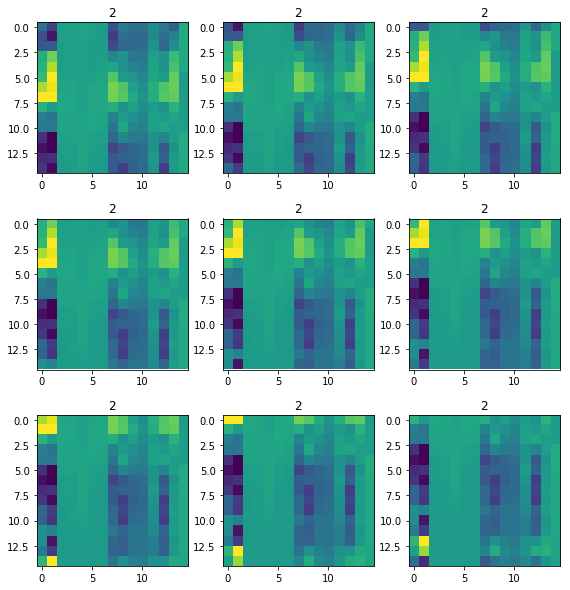

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [40]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(Xs,
                                              ys, 
                                              test_size=0.1,#切分比例
                                              random_state=42, #隨機種子
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2484, 15, 15, 1) (2484, 3) (276, 15, 15, 1) (276, 3)


# 人為切分

In [0]:
#test_num = 200
#index_train ,index_val = indexs[:-test_num],indexs[-test_num:]
#xtrain, xval, ytrain, yval = Xs[:-test_num],Xs[-test_num:],ys[:-test_num],ys[-test_num:]
#print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)
#print(index_train[-1],index_val[-1])

# 看一下樣本的label分布情況是否平均(待解決)

In [42]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

0    1534
2    1014
1     212
dtype: int64

In [43]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

0    1375
2     919
1     190
dtype: int64

In [44]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

0    159
2     95
1     22
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [46]:
model = Sequential()

dim1 = days #觀察時間
dim2 = len(features) #特徵數量
nclasses = 3 

# two convolutional layers (15x15x32, 15x15x64), 
#兩層conv+maxpool+dropout
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#全連接層
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(nclasses, activation='softmax'))#分類輸出漲或跌
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    


In [47]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=20, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.000001)
#2
es = EarlyStopping(monitor='val_loss', #驗證集loss
                   min_delta=0, 
                   patience=30,  
                   mode='min',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [49]:
history = model.fit(xtrain,ytrain,
                    batch_size=128,
                    epochs=200,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[lr_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2484 samples, validate on 276 samples
Epoch 1/200
2484/2484 [==============================] - 2s 783us/step - loss: 0.8975 - acc: 0.5165 - val_loss: 0.8342 - val_acc: 0.5870
Epoch 2/200
2484/2484 [==============================] - 0s 97us/step - loss: 0.8300 - acc: 0.5668 - val_loss: 0.8047 - val_acc: 0.5833
Epoch 3/200
2484/2484 [==============================] - 0s 93us/step - loss: 0.8095 - acc: 0.5737 - val_loss: 0.7884 - val_acc: 0.6051
Epoch 4/200
2484/2484 [==============================] - 0s 95us/step - loss: 0.7968 - acc: 0.5829 - val_loss: 0.7907 - val_acc: 0.6051
Epoch 5/200
2484/2484 [==============================] - 0s 92us/step - loss: 0.7913 - acc: 0.5821 - val_loss: 0.7807 - val_acc: 0.6051
Epoch 6/200
2484/2484 [==============================] - 0s 93us/step - loss: 0.7933 - acc: 0.5821 - val_loss: 0.7805 - val_acc: 0.6123
Epoch 7/200
2484/2484 [===================

# 訓練過程評估

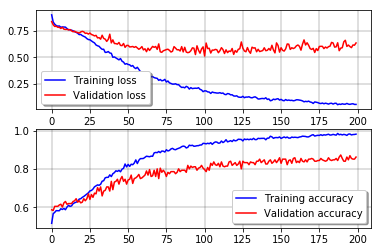

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

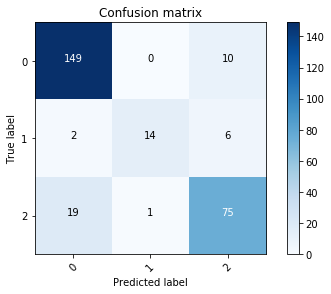

In [51]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [52]:
y_pred = model.predict(xval)#[[0.6,0.4],[0.4,0.6]]
y_pred = [np.argmax(i) for i in y_pred]#[0,1]
y_pred = to_categorical(y_pred, num_classes = 3)#[[1,0],[0,1]]
print(y_pred[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


真實y值

In [53]:
print(yval[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


分類報告

In [54]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']#漲跌
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.88      0.94      0.91       159
         BUY       0.93      0.64      0.76        22
        SELL       0.82      0.79      0.81        95

   micro avg       0.86      0.86      0.86       276
   macro avg       0.88      0.79      0.82       276
weighted avg       0.86      0.86      0.86       276
 samples avg       0.86      0.86      0.86       276



# plot error

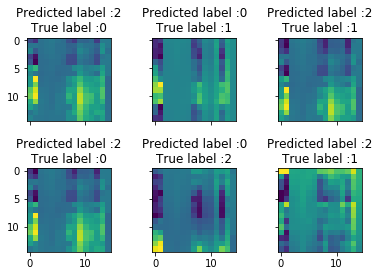

In [55]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)